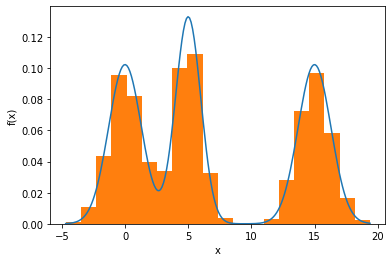

In [ ]:
import numpy as np
import numpy.random
import scipy.stats as ss
import matplotlib.pyplot as plt

# Set-up.
n = 10000
numpy.random.seed(0x5eed)
# Parameters of the mixture components
norm_params = np.array([[5, 1],
                        [0, 1.3],
                        [15, 1.3]])
n_components = norm_params.shape[0]
# Weight of each component, in this case all of them are 1/3
weights = np.ones(n_components, dtype=np.float64) / 3.0
# A stream of indices from which to choose the component
mixture_idx = numpy.random.choice(len(weights), size=n, replace=True, p=weights)
# y is the mixture sample
y = numpy.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                   dtype=np.float64)

# Theoretical PDF plotting -- generate the x and y plotting positions
xs = np.linspace(y.min(), y.max(), 200)
ys = np.zeros_like(xs)

for (l, s), w in zip(norm_params, weights):
    ys += ss.norm.pdf(xs, loc=l, scale=s) * w

plt.plot(xs, ys)
plt.hist(y, density=True, bins="fd")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

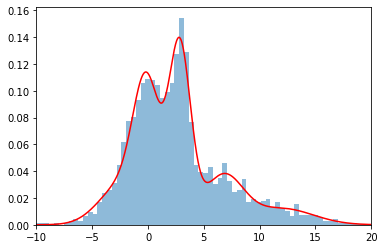

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.mixture import GaussianMixture

x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)]).reshape(-1,1)

num_gaussians = 5
clf = GaussianMixture(n_components = num_gaussians, max_iter = 500, random_state = 0).fit(x)

xpdf = np.linspace(-10,20,1000).reshape((-1,1))
density = np.exp(clf.score_samples(xpdf))
plt.hist(x, bins = 80, density = True, alpha=0.5)

plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

# Gaussian Mixture Model Selection

Consider that $Z_i \in {1,\ldots,K}$ is random variable representing the component that generated example $x^{(i)}$ in a GMM composed of $K$ gaussians. Then, its log-likelihood is defined as:
\begin{align}
\ell(\theta) &= \log \Pr(x^{(1)}, x^{(2)}, \ldots, x^{(m)}) = \\
&= \log \prod_{i=1}^{i=m} \Pr(x^{(i)}) = \\
&= \sum_{i=1}^{i=m} \log \left(\Pr(x^{(i)})\right) = \\
&= \sum_{i=1}^{i=m} \log \left(\sum_{k=1}^{k=K} \Pr(Z_i = k)\Pr(x^{(i)} \mid Z_i = k)\right) = \\
&= \sum_{i=1}^{i=m} \log \left( \sum_{k=1}^K \pi_k N(x^{(i)};\mu_k, \sigma_k^2) \right )
\end{align}

See more details [here](https://stephens999.github.io/fiveMinuteStats/intro_to_mixture_models.html) and [here](https://stephens999.github.io/fiveMinuteStats/intro_to_em.html).

BIC and AIC, two criteria for model selection in GMMs are functions of the log-likelihood $\ell$ of the data and of $p$, the amount of parameters of the mixture model (e.g, for a mixture model of $K=2$ gaussians, $p=3K-1 = 6-1=5$).

It is worth mentioninig that both AIC and BIC are general model selection criteria (i.e., they are not restricted to GMMs).

### Bayesian Information Criterion (BIC)

$$
BIC = \max_p \left(\ell - \frac{1}{2}p \log m \right)
$$

### Akaike Information Criterion (AIC)

$$
AIC = \min_p \left(2p - \ell\right)
$$



## Example
Example adapted from https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html

In [ ]:
!pip install bayespy

     |████████████████████████████████| 491kB 6.1MB/s 
  Created wheel for bayespy: filename=bayespy-0.5.22-cp37-none-any.whl size=379429 sha256=ea6326372d853c28ddeea7de06322970e07828ce5324d7000fa203b3a34728ee
  Stored in directory: /root/.cache/pip/wheels/e8/32/77/9d0787cae2c5483aafada817a65e84cb086d52079ab9692be7
Successfully built bayespy


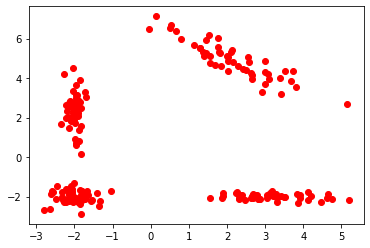

In [47]:
import numpy as np
np.random.seed(1)
y0 = np.random.multivariate_normal([3, -2], [[1, 0], [0, 0.02]], size=50)
y1 = np.random.multivariate_normal([-2, 2], [[0.02, 0], [0, 1]], size=50)
y2 = np.random.multivariate_normal([2, 5], [[1, -0.9], [-0.9, 1]], size=50)
y3 = np.random.multivariate_normal([-2, -2], [[0.1, 0], [0, 0.1]], size=50)
X = np.vstack([y0, y1, y2, y3])

import bayespy.plot as bpplt
bpplt.pyplot.plot(X[:,0], X[:,1], 'ro')
bpplt.pyplot.show()

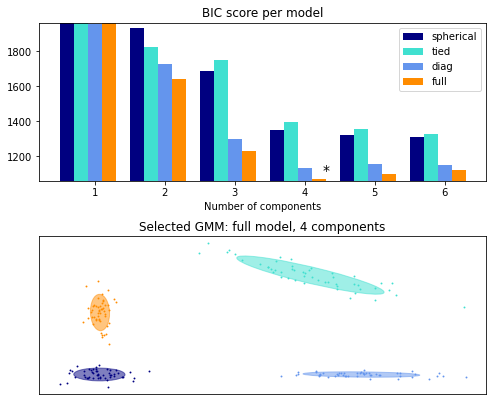

In [60]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']

bics = dict()

for cv_type in cv_types:
    bics[cv_type] = []
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        bics[cv_type].append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(f'Selected GMM: {best_gmm.covariance_type} model, '
          f'{best_gmm.n_components} components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

[1962.4431196031312, 1578.280683792034, 1231.4714269081728, 1069.8194306506332, 1094.7415352511061, 1117.3306963240138]


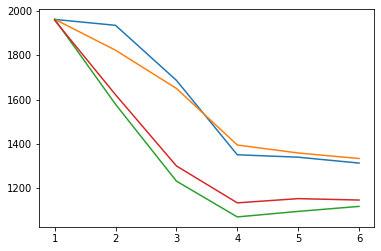

In [59]:
plt.xticks(n_components_range)
print(bics['full'])
plt.plot(n_components_range, bics['spherical'], label='BIC-spherical')
plt.plot(n_components_range, bics['tied'], label='BIC-tied')
plt.plot(n_components_range, bics['full'], label='BIC-full')
plt.plot(n_components_range, bics['diag'], label='BIC-diag')